In [301]:
from utils import *


Download Data

In [302]:
# download_data("2020")
spark.catalog.clearCache()

Load into into spark

In [303]:
df_ = load_data("2020")
df_.createOrReplaceTempView("dfTable")
df = spark.sql("SELECT * FROM dfTable LIMIT 10")
# df.show()


Transform dataframe

In [304]:
sections = ["section_1", 
            "section_1A", 
            "section_1B", 
            "section_2", 
            "section_3", 
            "section_4", 
            "section_5", 
            "section_6", 
            "section_7", 
            "section_7A", 
            "section_8", 
            "section_9",
            "section_9A", 
            "section_9B", 
            "section_10",  
            "section_11", 
            "section_12", 
            "section_13", 
            "section_14", 
            "section_15"]


In [305]:
stack_expr_str = ','.join([f"'{s}', {s}" for s in sections])
df_stacked = df.selectExpr("filename", "cik", "year", 
                           f"stack({len(sections)}, {stack_expr_str}) as (sections, document)")
# df_stacked.show()

Create Embeddings

In [306]:
chunk_text_udf = udf(chunk_text, ArrayType(StringType()))
embed_udf = udf(embed, VectorUDT())

def chunk_and_embed(df):
    df_chunked = df.withColumn("chunks", chunk_text_udf(col("document"))) 
    df_exploded = df_chunked.withColumn("chunk", explode(col("chunks")))
    return df_exploded.withColumn("embeddings", embed_udf(col("chunk"))) 


In [308]:
df_embed = chunk_and_embed(df_stacked)
# df_embed.show()

In [ ]:
df_embed.write.partitionBy("sections").format("parquet").mode("overwrite").save("./processed_data")

Load Data for ML

In [259]:
df_ml = spark.read.parquet("./processed_data")

* Standard Scaliing

In [260]:
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml.clustering import KMeans

scaler = StandardScaler(inputCol="embeddings", outputCol="embeddings_scaled", withStd=True, withMean=True)
df_scaled = scaler.fit(df_ml).transform(df_ml)


* PCA

In [261]:
explained_var_bound = (0.8, 0.81)
embed_dim = df_ml.first()["embeddings"].shape[0]
kl, kr = 1, embed_dim
while True:
    k = (kl + kr) // 2
    pca = PCA(k=k, inputCol="embeddings_scaled", outputCol="embeddings_pcs").fit(df_scaled)
    explained_var = pca.explainedVariance.sum()
    if k == kl: break
    if explained_var < explained_var_bound[0]:
        kl = k
    elif explained_var > explained_var_bound[1]:
        kr = k
    else:
        break

print(f"{k} components of {embed_dim} input dimensions are required to capture {explained_var:.4f} fraction of variance")
df_pca = pca.transform(df_scaled)


105 components of 384 input dimensions are required to capture 0.8055 fraction of variance


* Kmeans

In [262]:
import matplotlib_inline
import matplotlib.pyplot as plt
%matplotlib inline

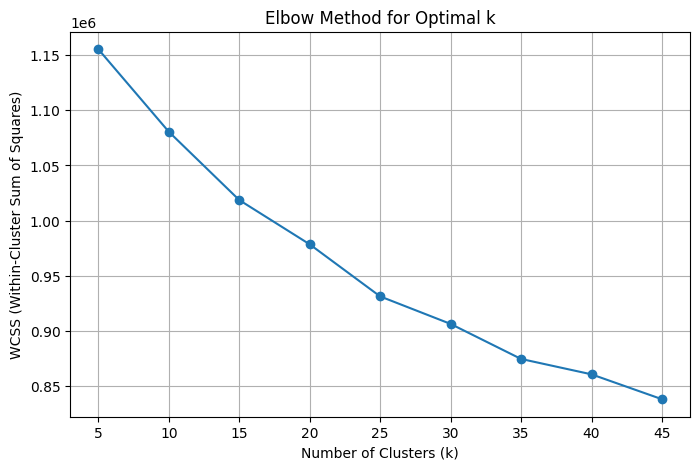

In [263]:
costs = []
k_values = range(5, 50, 5)  
for k in k_values:
    kmeans = KMeans(featuresCol="embeddings_pcs", predictionCol="cluster", k=k, seed=0)
    model = kmeans.fit(df_pca)
    cost = model.summary.trainingCost  # Get WCSS (Within-Cluster Sum of Squares)
    costs.append(cost)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, costs, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.grid(True)
plt.show()
# kmeans = KMeans(featuresCol="embeddings_pcs", predictionCol="cluster", k=2, seed=0)

In [264]:
k_opt = 25 #Chooseing 25 clusters by visual inspection of the elbow curve
model = KMeans(featuresCol="embeddings_pcs", predictionCol="cluster", k=k_opt, seed=0).fit(df_pca)
df_clusters = model.transform(df_pca)
# df_clusters.show()

* Get Outliers

In [265]:
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import FloatType
from numpy.linalg import norm

cluster_centers = model.clusterCenters()
get_center_udf = udf(
    lambda cluster_idx: Vectors.dense(cluster_centers[cluster_idx]),
    VectorUDT()
)

# Add center column
df_with_centers = df_clusters.withColumn(
    "cluster_center",
    get_center_udf(col("cluster"))
)

# UDF to calculate Euclidean distance
def calculate_distance(features_vec, center_vec):
    return float(norm(features_vec.toArray() - center_vec.toArray()))

distance_udf = udf(calculate_distance, FloatType())

# Calculate distance for each row
final_df = df_with_centers.withColumn(
    "distance_to_center",
    distance_udf(col("embeddings_pcs"), col("cluster_center"))
)

# Show results
# final_df.show()

In [266]:
from pyspark.sql.functions import col, when, percentile_approx

percentile_threshold = 0.95
distance_threshold = list(final_df.select(percentile_approx(col("distance_to_center"), percentile_threshold)).collect()[0].asDict().values())[0]
final_df = final_df.withColumn("outlier_flag", when(col("distance_to_center") > distance_threshold, 1).otherwise(0))

# final_df.show()



* Plots

In [ ]:
import os

# Choose relevant columns
df_pandas = final_df.select(["sections", "embeddings", "cluster", "outlier_flag"]).toPandas()


In [280]:
import umap
import numpy as np
import pandas as pd

reducer = umap.UMAP(min_dist=0.4, n_neighbors=50)
data = np.vstack(df_pandas["embeddings"].apply(lambda x: x.toArray()).values)
umap_embds = reducer.fit_transform(data)
df_embds_2d = pd.DataFrame(data=umap_embds, columns=["embds_2d_x", "embds_2d_y"])
df_new = pd.concat([df_pandas, df_embds_2d], axis=1)
df_plot = df_new[["sections", "cluster", "outlier_flag", "embds_2d_x", "embds_2d_y"]]

/mnt/c/Programming/WSL/AIG_/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


##### Embeddings in 2D

In [295]:
import seaborn as sns
os.makedirs("./plots/task1", exist_ok=True)

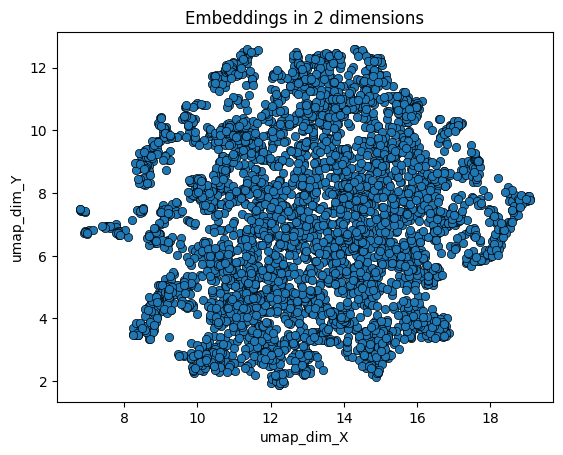

In [296]:

sns.scatterplot(data=df_plot, x="embds_2d_x", y="embds_2d_y", edgecolors="k")
plt.title("Embeddings in 2 dimensions")
plt.xlabel("umap_dim_X")
plt.ylabel("umap_dim_Y")
plt.savefig("./plots/task1/embeddings_in_2D.jpg", dpi=300, bbox_inches='tight')

##### Clusters

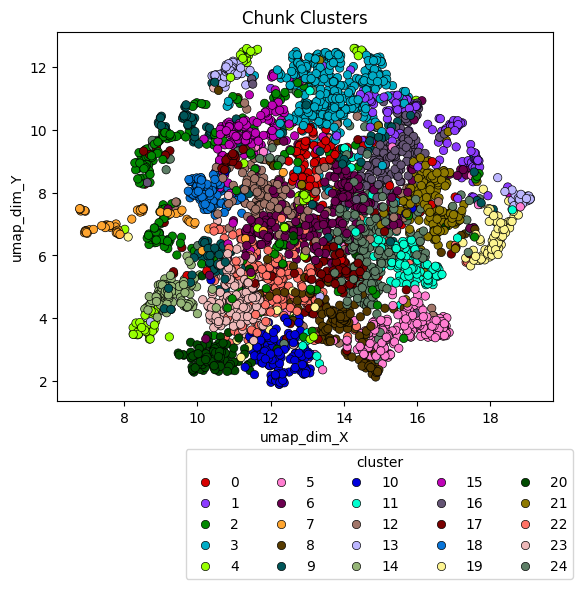

In [297]:
import colorcet as cc
palette = sns.color_palette(cc.glasbey, n_colors=25)
ax = sns.scatterplot(data=df_plot, x="embds_2d_x", y="embds_2d_y", hue="cluster", palette=palette, edgecolors="k")
plt.title("Chunk Clusters")
plt.xlabel("umap_dim_X")
plt.ylabel("umap_dim_Y")
sns.move_legend(ax, "lower center", ncol=5, bbox_to_anchor=(0.65, -0.5))
plt.savefig("./plots/task1/chunk_clusters.jpg", dpi=300, bbox_inches='tight')

##### Outliers

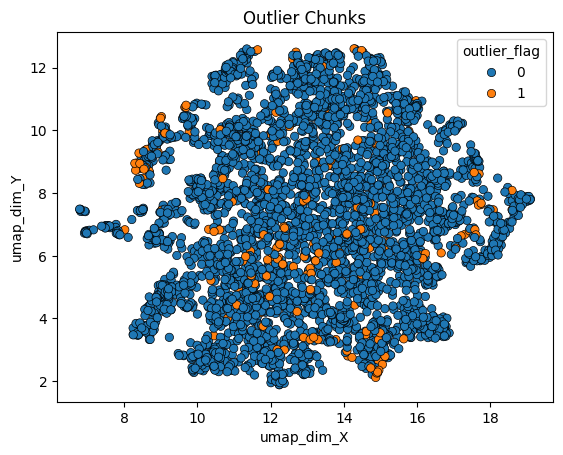

In [298]:
ax = sns.scatterplot(data=df_plot, x="embds_2d_x", y="embds_2d_y", hue="outlier_flag", edgecolors="k")
plt.title("Outlier Chunks")
plt.xlabel("umap_dim_X")
plt.ylabel("umap_dim_Y")
plt.savefig("./plots/task1/outlier_chunks.jpg", dpi=300, bbox_inches='tight')

##### Sections

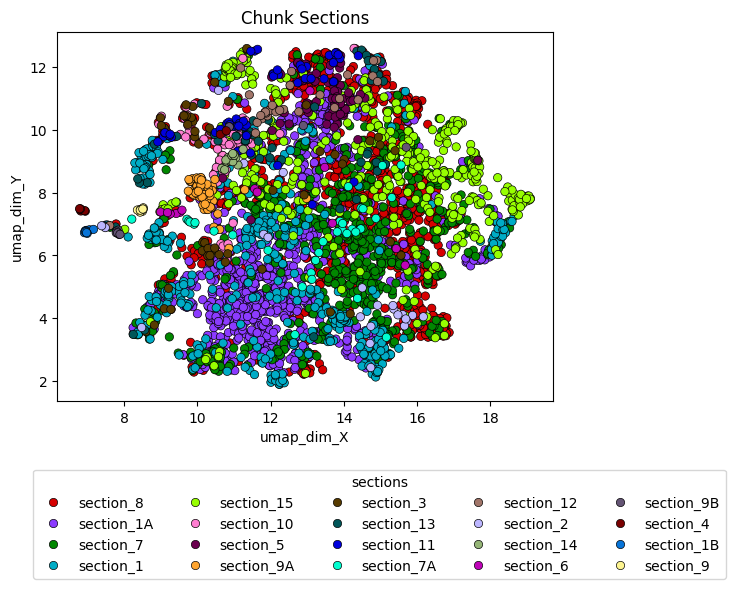

In [299]:
n_secs = len(df_plot["sections"].unique())
palette = sns.color_palette(cc.glasbey, n_colors=n_secs)
ax = sns.scatterplot(data=df_plot, x="embds_2d_x", y="embds_2d_y", hue="sections", palette=palette, edgecolors="k")
plt.title("Chunk Sections")
plt.xlabel("umap_dim_X")
plt.ylabel("umap_dim_Y")
sns.move_legend(ax, "lower center", ncol=5, bbox_to_anchor=(0.65, -0.5))
plt.savefig("./plots/task1/sections.jpg", dpi=300, bbox_inches='tight')